# Humanizing Customer Complaints 


### **Problem Defination:** a supervised (labelled) text multi-class classification problem, of which our goal is to make a prediction (assign to correct category) with a new input (complaint).

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koushiktcs12","key":"4004aba149297e662c11063e50b8ef45"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                     title                                         size  lastUpdated          downloadCount  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                             429KB  2020-11-13 12:45:46           3205  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                      353MB  2020-11-09 18:51:59           2013  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University     2MB  2020-11-13 06:04:14            885  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates      199MB  2020-10-23 16:56:10            381  
etsc9287/2020-general-election-polls                    2020 General Election Polls                  109KB  2020-02-09 08:20:59   

In [66]:
!pip install spacy-langdetect
!pip install language-detector
import nltk

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Section 1: Importing Packages and Loading Data

In [67]:
import numpy as np
import pandas as pd

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import chi2

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle
from google.colab import files
seed =300

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Data Source** Kaggle https://www.kaggle.com/cfpb/us-consumer-finance-complaints
### Original data source: https://files.consumerfinance.gov/ccdb/complaints.csv.zip

In [68]:
!kaggle datasets download -d cfpb/us-consumer-finance-complaints
!unzip \*.zip  && rm *.zip
!ls

 77% 65.0M/84.5M [00:00<00:00, 69.2MB/s]
100% 84.5M/84.5M [00:00<00:00, 133MB/s] 
Archive:  us-consumer-finance-complaints.zip
replace consumer_complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: consumer_complaints.csv  
  inflating: database.sqlite         
cc_fitted_tfidf_to_use.pickle
cc_logit_finalized.pickle
confusion_matrix.png
consumer_complaints.csv
database.sqlite
df_cc_data.pickle
freq_of_removed_classes_and_reduced_observations.png
freq_of_uncombined_class.png
glove.6B.50d.txt
kaggle.json
results_cv_straitified_1gram_df.pickle
sample_data


In [69]:
# # Load CSV file
df= pd.read_csv(r'consumer_complaints.csv')
df.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [70]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'date_received':'DATE_RECEIVED',
                  'product':'PRODUCT',
                  'sub_product':'SUB_PRODUCT',
                  'issue':'ISSUE',
                  'sub_issue':'SUB_ISSUE',
                  'consumer_complaint_narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'company_public_response':'COMPANY_PUBLIC_RESPONSE',
                   'company':'COMPANY',
                   'state':'STATE',
                   'zipcode':'ZIP_CODE',
                   'tags':'TAGS',
                   'consumer_consent_provided':'CONSUMER_CONSENT_PROVIDED',
                   'submitted_via':'SUBMITTED_VIA',
                   'date_sent_to_company':'DATE_SENT_TO_COMPANY',
                   'company_response_to_consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'timely_response':'TIMELY_RESPONSE',
                   'consumer_disputed?':'CONSUMER_DISPUTED',
                   'complaint_id':'COMPLAINT_ID'
                  }, inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   DATE_RECEIVED                 555957 non-null  object
 1   PRODUCT                       555957 non-null  object
 2   SUB_PRODUCT                   397635 non-null  object
 3   ISSUE                         555957 non-null  object
 4   SUB_ISSUE                     212622 non-null  object
 5   CONSUMER_COMPLAINT_NARRATIVE  66806 non-null   object
 6   COMPANY_PUBLIC_RESPONSE       85124 non-null   object
 7   COMPANY                       555957 non-null  object
 8   STATE                         551070 non-null  object
 9   ZIP_CODE                      551452 non-null  object
 10  TAGS                          77959 non-null   object
 11  CONSUMER_CONSENT_PROVIDED     123458 non-null  object
 12  SUBMITTED_VIA                 555957 non-null  object
 13 

### Section 1.1.1: Dropping all rows that do not have Customer Complaint entries in them

In [72]:
df = df[df["CONSUMER_COMPLAINT_NARRATIVE"].notnull() == True]
df = df.drop_duplicates()
print(df.shape)

(66806, 18)


In [73]:
df['PRODUCT'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: PRODUCT, dtype: int64

In [74]:
## Combining Loans together to make this a simplier classification problem
df.replace('Student loan', 'Loan', inplace=True)
df.replace('Consumer Loan', 'Loan', inplace=True)
df.replace('Payday loan', 'Loan', inplace=True)
df.replace('Vehicle loan or lease', 'Loan', inplace=True)
df.replace('Payday loan, title loan, or personal loan', 'Loan', inplace=True)
df.replace('Money transfer, virtual currency, or money service', 'Money transfers', inplace=True)

# Placing Virtual currency into other financial service
df.replace('Virtual currency', 'Other financial service', inplace=True)

In [75]:
df['PRODUCT'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Loan                        6532
Bank account or service     5711
Prepaid card                 861
Money transfers              666
Other financial service      110
Name: PRODUCT, dtype: int64

## PRODUCT column, we observe 10 classes with the following distribution:

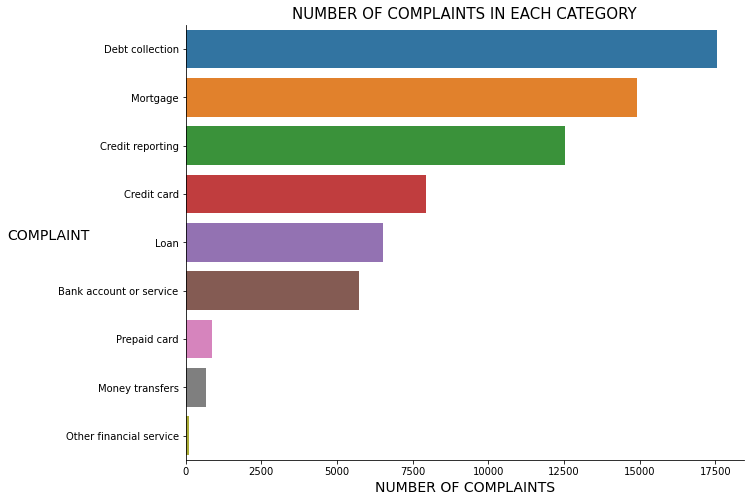

In [76]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df, 
                   order=df['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

## Some of the classes (products), however, overlap. For instance, Credit card or prepaid card clash with Credit card and Prepaid card. 

In [77]:
product_nm = 'Credit card'

In [78]:
df=df[(df['PRODUCT']==product_nm)]
print(df[['PRODUCT','ISSUE']].value_counts())

PRODUCT      ISSUE                                   
Credit card  Billing disputes                            1222
             Other                                        828
             Identity theft / Fraud / Embezzlement        718
             Closing/Cancelling account                   618
             Customer service / Customer relations        416
             Delinquent account                           404
             Advertising and marketing                    385
             APR or interest rate                         381
             Late fee                                     357
             Billing statement                            301
             Rewards                                      286
             Credit card protection / Debt protection     263
             Transaction issue                            250
             Credit determination                         247
             Other fee                                    220
             Pay

### Can merge *fees and lees than 1% merge into other

In [79]:
print(df[['PRODUCT','ISSUE']].value_counts(normalize = True)*100)

PRODUCT      ISSUE                                   
Credit card  Billing disputes                            15.411780
             Other                                       10.442679
             Identity theft / Fraud / Embezzlement        9.055366
             Closing/Cancelling account                   7.794173
             Customer service / Customer relations        5.246563
             Delinquent account                           5.095220
             Advertising and marketing                    4.855593
             APR or interest rate                         4.805146
             Late fee                                     4.502459
             Billing statement                            3.796191
             Rewards                                      3.607012
             Credit card protection / Debt protection     3.316938
             Transaction issue                            3.152983
             Credit determination                         3.115147
        

## Section 1.1: Data Cleaning

### Section 1.1.2: Subsetting Dataframe for Text Multi-Classification Problem

In [80]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_cc = df[['ISSUE', 'CONSUMER_COMPLAINT_NARRATIVE']].copy()

# Renaming columns to something easier
df_cc.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True)

In [81]:
# Pickling our subsetted dataframe
with open('df_cc_data.pickle', 'wb') as to_write:
     pickle.dump(df_cc, to_write)

In [82]:
# Loading our pickled subsetted dataframe
with open('df_cc_data.pickle', 'rb') as to_read:
    df_cc = pickle.load(to_read)

# Section 2: Understanding/Cleaning Our Data

In [83]:
# Checking our dataframe
df_cc.info()
# Great! We have no null values in each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7929 entries, 190263 to 553006
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ISSUE               7929 non-null   object
 1   CONSUMER_COMPLAINT  7929 non-null   object
dtypes: object(2)
memory usage: 185.8+ KB


## Section 2.1: Exploring Consumer Complaints for Product = 'Credit card'

## Section 2.2: Exploring Issue category

### Section 2.2.1: Data Visualization on Categories in PRODUCT

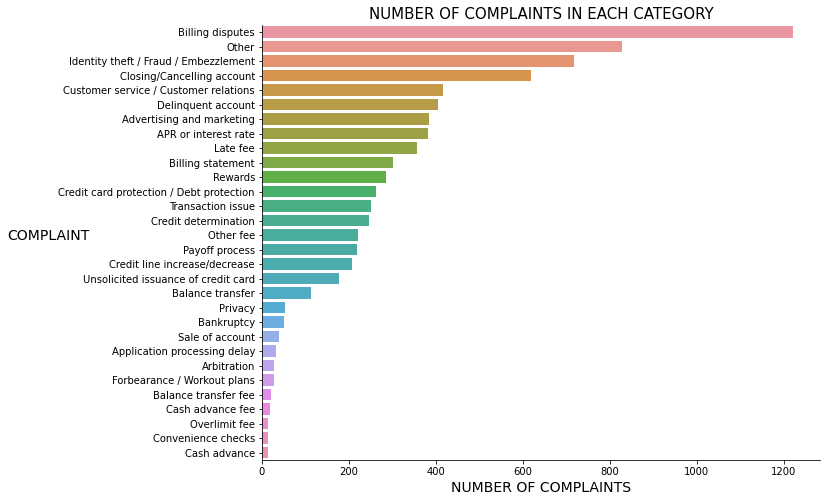

In [84]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_cc, 
                   order=df_cc['ISSUE'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

### Section 2.2.3: Data Visualizing on newly combined classes

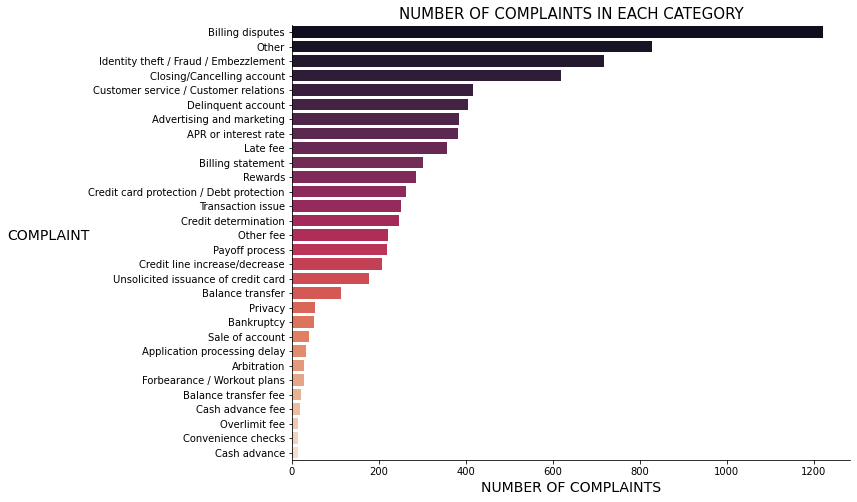

In [86]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_cc, 
                   order=df_cc['ISSUE'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )
ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

We can see from the graph that there lies a major class imbalance (again)  
We have to deal with this when we are going to use our model for prediction  
Now we are doing multilabel prediction. HOORAY!

### Section 2.2.4: Label Encoding Categories

In [87]:
# Applying encoding to the ISSUE column
df_cc['ISSUE_ID'] = df_cc['ISSUE'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the ISSUE column


# Creates a dataframe of the ISSUE to their respective ISSUE_ID
category_id_df = df_cc[['ISSUE', 'ISSUE_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a ISSUE: ISSUE_ID key-value pair
id_to_category = dict(category_id_df[['ISSUE_ID', 'ISSUE']].values)  # Creates a ISSUE_ID: ISSUE key-value pair

# New dataframe
df_cc.head(10)

,ISSUE,CONSUMER_COMPLAINT,ISSUE_ID
190263,Other,i opened XXXX Bank of America credit cards 15-...,0
190587,Other,Mel S. Harris & assoc. used deceptive collecti...,0
192008,Identity theft / Fraud / Embezzlement,In late XX/XX/XXXX or early XX/XX/XXXX I recei...,1
192115,Late fee,I have credit cards with CitiCard and XXXX XXX...,2
192150,Advertising and marketing,I accepted a credit card off for the Barclays ...,3
192471,Closing/Cancelling account,My Complaint is in regards to my credit card w...,4
192485,Other,I applied for a credit card and was accepted f...,0
192496,Identity theft / Fraud / Embezzlement,"I would like to be credited in full, of all th...",1
192624,Credit determination,i recently closed and paid off my citizens ban...,5
195501,Customer service / Customer relations,I have XXXX credit cards with Capital One. I h...,6


In [88]:
# We still get the same length as per the original df.
len(df_cc)

7929

Now that we have encoded our columns, time to move on to the next step -- cleaning the fricken text data  
But let's save our dataframe here so we don't run into memory issues later and we can start from a new starting point fruther down the notebook

### Section 2.2.5: Text Pre-Processing

In [89]:
# Looking at a sample text
sample_complaint = list(df_cc.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

["I accepted a credit card off for the Barclays XXXX XXXX. The initial disclosure provided to me indicated a promotional rate of 0.00 APR on purchases ( 6 months ) and balance transfers ( for 15 months ). Upon receiving my card the disclosure provided did not reference the promotional rate on the balance transfers, therefore I called the company to discuss and was told the promotional was only on purchases. Therefore, I submitted a complaint through the bank 's website on XXXX/XXXX/15. After several back and forth responses and a letter received, it was still being indicated the promotional rate is only on purchases. As already expressed this is not what was initially disclosed to me and therefore this is deceptive to me as a consumer as I made a credit decision based on the initially information provided to me that appear to be false. I have provided the link below that provided the terms and conditions of the card that included the promotional rate of balance transfers. My other conc

In [90]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['00', '15', 'accepted', 'action', 'app', 'appear', 'apply', 'apr', 'balance', 'bank', 'barclaycardus', 'barclays', 'based', 'called', 'card', 'com', 'company', 'complaint', 'concern', 'conditions', 'conducting', 'consumer', 'credit', 'deceptive', 'decision', 'did', 'disclosed', 'disclosure', 'discuss', 'expressed', 'false', 'forth', 'https', 'included', 'indicated', 'information', 'initial', 'initially', 'japply', 'jsp', 'landing', 'letter', 'link', 'lp', 'months', 'practices', 'promotional', 'provided', 'purchases', 'rate', 'received', 'receiving', 'reference', 'responses', 'submitted', 'terms', 'tncs', 'told', 'transfers', 'website', 'www', 'xxxx']


Ok so basically, we can trust the stop_word removal from tfidf.   
Through the tests, we see that it removes punctuations and also all the stopwords.   
(I deleted these because they were seriously taking up a lot of space on my jupyter notebook)  
Spellchecker might also mess up some words, especially with bank names like Citi for example  
Thus changing the semantic meaning of the word.  
  
Therefore, we are going to just use tfidf just as it is.  
It's pretty amazing, really.  
  
Great! We can start building some shit!  

# Section 3: Model/Classifier Selection
#### Each model is cross-validated on a stratified 5-fold split train-validation (of 80% of the whole dataset). The remaining 20% data was held out and untouched to simulate how our final chosen model would perform in real-life scenarios

## Section 3.1: Train/StratifiedCV/Test split

In this section, we also prepare the model for text pre-processing. This is handled by our handydandy Tfidfvecotirzer with the stop_words and such. As we have tested above, it also ignores punctuation so it really is quite a catch-all package that cleans our text really well for the purposes of doing text classification

In [91]:
# Split the data into X and y data sets
X, y = df_cc.CONSUMER_COMPLAINT, df_cc.ISSUE_ID
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (7929,) y shape: (7929,)


In [92]:
# Split the data into X and y data sets
X, y = df_cc.CONSUMER_COMPLAINT, df_cc.ISSUE_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (7929,) y shape: (7929,)
X_train (6343,)
y_train (6343,)
X_test (1586,)
y_test (1586,)


## Section 2.2: Vectorization
#### To turn words into something a machine learning algorithm can understand and process, we need to do something called vectorization.
##### Put simply, this is the process of turning words into multi-dimensional vectors in such a way that the meaning or context of the word is correlated with where that vector points. In a sense, vectorization allows computers to quantify the meaning of words by mapping similar word meanings to similar vector spaces.

In [93]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)


# # StratifiedKFold -> Split 5
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

## Term Frequency — Inverse Document Frequency Vectorization
#### For this application, we want context-based vectorization. This is where Term frequency inverse document frequency vectorization comes in (TF-IDF). This vectorization method looks at the number of times a word appears in a comment relative to the number of times it appears in other comments. Two things result in a higher TF-IDF score:

   1. Higher frequency of the word within the specific complaint being scored.
   2. Lower frequency of the word across all other complaints.

## Section 3.2: Baseline Model - Train/Stratified CV with MultinomialNB()

In [94]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)

1-gram number of (rows, features): (6343, 5034)


### Evaluation Metrics (Accuracy, Recall_macro, Precission_macro, f1_macro, Recall_weighted, Precission_weighted, f1_weighted)
Referrence:
https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1


In [95]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })

## Section 3.3: Further Train/Straitified CV with other Models

### Section 3.3.1: 1-gram

In [97]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

In [98]:
results_cv_straitified_1gram

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,MultinomialNB1,0.230176,0.142337,0.069107,0.062046,0.274313,0.230176,0.157324,9.177880
1,0,GaussianNB1,0.152451,0.094767,0.070499,0.074990,0.146575,0.152451,0.136149,64.574370
2,0,LogisticRegression1,0.387359,0.318203,0.204730,0.212778,0.411003,0.387359,0.349319,875.808542
3,0,RandomForest1,0.189026,0.157409,0.049554,0.036006,0.334421,0.189026,0.100353,96.982901
4,0,LinearSVC1,0.366546,0.286060,0.252944,0.256695,0.347724,0.366546,0.349839,26.963011


### Logistic Regression gives us the highest accuracy of 39%.

In [99]:
# Saving our results because I don't wanna re-train the whole damn thing
with open('results_cv_straitified_1gram_df.pickle', 'wb') as to_write:
  pickle.dump(results_cv_straitified_1gram, to_write)

In [100]:
# Loading our pickled results
with open('results_cv_straitified_1gram_df.pickle', 'rb') as to_read:
    results_cv_straitified_1gram = pickle.load(to_read)

### Section 3.3.2: 2-gram (Keep running into memory issues, therefore, this will not be tested anymore)

In [101]:
### Keep running into memory issues with 2-gram. Therefore, will not test it anymore

'''# Testing on all Models using 2-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

# # to concat all models
results_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),
                                          metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),
                                          metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),
                                          metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),
                                          metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val, 5, 'LinearSVC2')
                                          ], axis=0).reset_index()'''

"# Testing on all Models using 2-gram \n\n# Initialize Model Object\ngnb = GaussianNB()\nmnb = MultinomialNB()\nlogit = LogisticRegression(random_state=seed)\nknn = KNeighborsClassifier()\ndecisiontree = DecisionTreeClassifier(random_state=seed)\nrandomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)\nlinearsvc = LinearSVC()\n\n# # to concat all models\nresults_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),\n                                          metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),\n                                          metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),\n                                          metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),\n                                          metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val,

In [102]:
#results_cv_straitified_2gram

Instead of utilizing Vectorization (Tf-idfVectorizer that we used above), we can utilize WordEmbedding on the complaints before feeding them into our classifiers.
https://towardsdatascience.com/word2vec-skip-gram-model-part-1-intuition-78614e4d6e0b

https://towardsdatascience.com/the-three-main-branches-of-word-embeddings-7b90fa36dfb9

In [103]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [104]:
# Loading our saved models
# Consider training on the whole data instead now?
# Pickle trained Model for use in Flask App
with open('cc_fitted_tfidf_to_use.pickle', 'wb') as to_write:
    pickle.dump(tfidf1, to_write)
with open('cc_fitted_tfidf_to_use.pickle', 'rb') as to_read:  # loading the fitted tfidf with our 80% trained data
    fitted_tfidf_to_use = pickle.load(to_read)

In [105]:
# Initializing our chosen logreg model
logit = LogisticRegression()

# Fitting our model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [106]:
# Pickle trained Model for use in Flask App
with open('cc_logit_finalized.pickle', 'wb') as to_write:
    pickle.dump(logit_finalized, to_write)
with open('cc_logit_finalized.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

In [107]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the ISSUE to their respective ISSUE_ID
    category_id_df = df_cc[['ISSUE', 'ISSUE_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a ISSUE: ISSUE_ID key-value pair
    id_to_category = dict(category_id_df[['ISSUE_ID', 'ISSUE']].values)  # Creates a ISSUE_ID: ISSUE key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.ISSUE.values, 
                   yticklabels=category_id_df.ISSUE.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------------------------------------------------------
LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:
---------------------------------------------------------


Final Test Accuracy Score (also micro F1) for LogisticRegression: 0.4250


Macro Precision Score for LogisticRegression: 0.3240
Macro Recall Score for LogisticRegression: 0.2406
Macro F1 score = 0.2526


Micro Precision Score for LogisticRegression: 0.4250
Micro Recall Score for LogisticRegression: 0.4250
Micro F1 score = 0.4250


Weighted Precision Score for LogisticRegression: 0.4323
Weighted Recall Score for LogisticRegression: 0.4250
Weighted F1 score = 0.3922


Classification report for LogisticRegression (1-gram):
                                           precision    recall  f1-score   support

                                   Other       0.25      0.36      0.29       166
   Identity theft / Fraud / Embezzlement       0.52      0.60      0.56       144
                                Late fee       0.57  

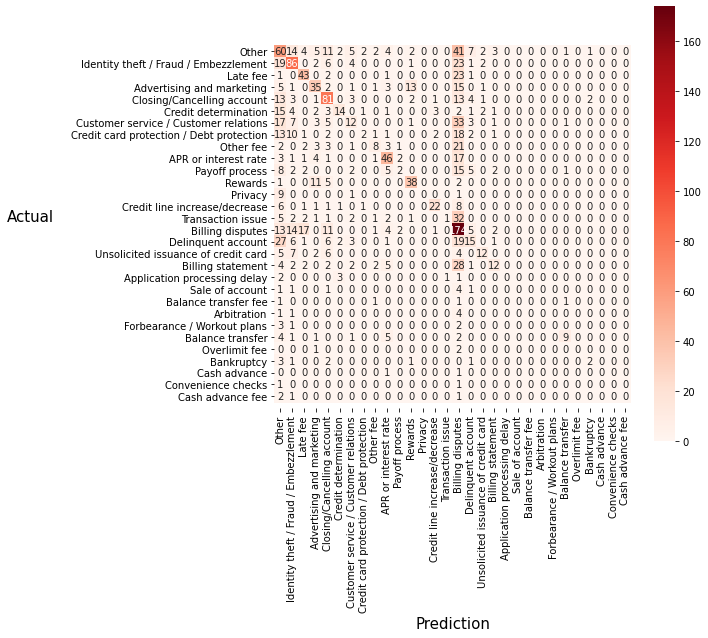

In [108]:
'''with open('results_highest_accuracy.pickle', 'rb') as to_read:
    results_highest_accuracy = pickle.load(to_read)

results_highest_accuracy'''

# Score model
print("---------------------------------------------------------")
print("LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:")
print("---------------------------------------------------------")
print('\n')
#print('Train/Cross-Validation Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(results_highest_accuracy.Accuracy.max()))
print('Final Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('\n')
print('Macro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))
print('\n')
print('Micro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('\n')
print('Weighted Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\n')
print('Classification report for LogisticRegression (1-gram):\n {}'.format(classification_report(y_test, 
                                                                                             y_pred,
                                                                                             target_names=df_cc.ISSUE.unique())))
print('Confusion Matrix for LogisticRegression (1-gram):\n'.format(conf_matrix(y_test, y_pred)))

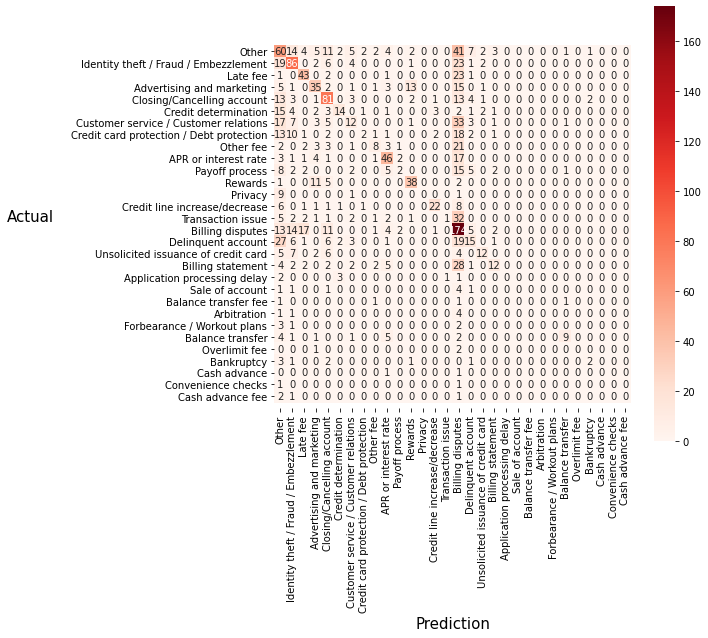

In [109]:
conf_matrix(y_test, y_pred)
plt.savefig('confusion_matrix', transparent=True)

## Section 5.1: Random Complaint 1

In [110]:
# Using our models

complaint = """
omg where is my money
aosidnoiandnaiosdnasd This is bullshit!! where is my money!!!
I TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.
WHAT KIND OF A BANK ARE YOU?
ARE YOU A BANK OR A THIEF?"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint = fitted_tfidf_to_use.transform([complaint])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint)
y_customized_prediction[0]

15

## Section 5.1: Random Complaint 2

In [111]:
# Using our models

complaint_2 = """
I borrowed money from you guys but it seems that the interest terms are unclear?
Please shed some more light on this because i seem to be overcharged this month and I don't want to pay more than I should
"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_2 = fitted_tfidf_to_use.transform([complaint_2])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_2)
y_customized_prediction

array([15])

In [112]:
# Not bad! Our model actually does do a pretty good job at predicting

## Section 5.2: Random Complaint 3 with no relevance at all

What about _completely_ irrelevant topics?

In [113]:
# Using our models

complaint_3 = """I love macdonalds"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_3 = fitted_tfidf_to_use.transform([complaint_3])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_3)
y_customized_prediction

array([0])

## Section 5.3: Random Complaint 4 with no relevance at all

In [114]:
# Using our models

complaint_4 = """Pair programming is not fun"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_4 = fitted_tfidf_to_use.transform([complaint_4])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_4)
y_customized_prediction

array([0])

### Comments:
It seems like everything that has no relevance tends to be classified as Other.  
So yes - there are cases therein which the model can incorrectly classify the Complaint.  
However, although our model is not going to be correct 100% of the time, it does do a pretty good job.  
It can handle very weird complaints where we throw in a complain that doesn't make a lot of sense.  
  
### Breaking our Model down:
It's great that we know that our model can do classifcation, but HOW does it do it? Let's dissect it and check what key words the model looks out for to classify a complaint.

# Section 6: Highest Occuring Words in each column

In [115]:
# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf2.fit_transform(df_cc.CONSUMER_COMPLAINT).toarray()
# Labelling our data
labels = df_cc.ISSUE_ID

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 7929 complaints is represented by 23116 features (TF-IDF score of unigrams and bigrams)


In [116]:
category_to_id

{'APR or interest rate': 9,
 'Advertising and marketing': 3,
 'Application processing delay': 19,
 'Arbitration': 22,
 'Balance transfer': 24,
 'Balance transfer fee': 21,
 'Bankruptcy': 26,
 'Billing disputes': 15,
 'Billing statement': 18,
 'Cash advance': 27,
 'Cash advance fee': 29,
 'Closing/Cancelling account': 4,
 'Convenience checks': 28,
 'Credit card protection / Debt protection': 7,
 'Credit determination': 5,
 'Credit line increase/decrease': 13,
 'Customer service / Customer relations': 6,
 'Delinquent account': 16,
 'Forbearance / Workout plans': 23,
 'Identity theft / Fraud / Embezzlement': 1,
 'Late fee': 2,
 'Other': 0,
 'Other fee': 8,
 'Overlimit fee': 25,
 'Payoff process': 10,
 'Privacy': 12,
 'Rewards': 11,
 'Sale of account': 20,
 'Transaction issue': 14,
 'Unsolicited issuance of credit card': 17}

In [117]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf2.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> APR or interest rate:
  * Most Correlated Unigrams are: 99, rate, apr
  * Most Correlated Bigrams are: 23 99, lower rate, lower apr

==> Advertising and marketing:
  * Most Correlated Unigrams are: offer, advertising, bonus
  * Most Correlated Bigrams are: night free, false advertising, xxxx bonus

==> Application processing delay:
  * Most Correlated Unigrams are: fabricated, application, withdrew
  * Most Correlated Bigrams are: process applying, mart credit, bank tried

==> Arbitration:
  * Most Correlated Unigrams are: prohibit, contracts, arbitration
  * Most Correlated Bigrams are: citibank refused, like cfpb, got paid

==> Balance transfer:
  * Most Correlated Unigrams are: balance, transfers, transfer
  * Most Correlated Bigrams are: transfer balance, balance transfers, balance transfer

==> Balance transfer fee:
  * Most Correlated Unigrams are: whichever, transfer, aaa
  * Most Correlated Bigrams are: balance transfer, transfer check, transfer fees

==> Bankruptcy:
  * M